# HAB Capstone Modeling 

## Contents:
[1. Introduction and Data Loading](#1)
 
[2. Linear Regression](#2)
 
[3. Ensemble Methods - Regression, Scaled Features](#3)
* [3.a. Random Forest Regressor](#3a)
* [3.b. XGBoost Regressor](#3b)
 
 
[4. Ensemble Methods - Regression, Unscaled Features](#4)
* [4.a. Random Forest Regressor](#4a)
* [4.b. XGBoost Regressor](#4b)
 
[5. Binary Classification with Ensemble Methods](#5)
* [5.a. Random Forest Classification](#5a)
* [5.b. XGBoost Classification](#5b)

[6. Model Recommendation and Feature Importance](#6)

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, recall_score, roc_auc_score, plot_roc_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV, cross_val_score, train_test_split, TimeSeriesSplit

import xgboost as xgb

import sys
sys.path.append('../src/')
from visualization.visualize import *

#set random seed for reproducibility
np.random.seed(seed=42)

## <a id='1'>1. Introduction and Data Loading</a>

The goal of this notebook is to train and test machine learning models for the purpose of predicting harmful algal bloom (HAB) events in the Western Basin of Lake Erie. The problem will be first approached as a regression problem to see if we can predict the microcystin concentration at a given location on a given day, then as a classification problem to see if we could predict various classes of microcystin concentration using the Ohio EPA cutoff values:
    <ul>
    <li>drinking limit - 1.6 µg/L</li>
    <li>recreation limit - 6 µg/L</li>
    <li>strict no-contact limit - 20 µg/L</li>
    </ul>
Finally we will also performed binary classification to sort samples into low and high microcystin classes using the Ohio EPA drinking limit of 1.6 µg/L as a cutoff value.

Data were originally sampled with weekly or biweekly frequency depending on the site and year. The data were upsampled to daily frequency with linear interpolation in order to apply time shifts to the features before downsampling to weekly frequency. For the scaled feature set skewed features were first log-transformed and then standardized. Features such as temperature and dissolved oxygen that were not heavily skewed were simply standardized. The final scaled features were then split into training and testing sets with a test size of 0.2. Please see the feature engineering notebook for details. 

In [2]:
#load unscaled data
unscaled = pd.read_csv('../data/processed/resampled_unscaled.csv', index_col=0, parse_dates=True)

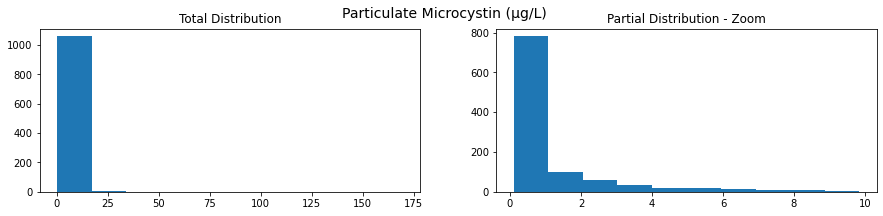

In [3]:
#visualize particulate microcystin distribution
hist_zoom(unscaled, 'Particulate Microcystin (µg/L)', cutoff=10)

In [4]:
print('All Measurements:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 0))
print('Greater than 1.6 µg/L:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 1.6))
print('Greater than 6 µg/L:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 6))
print('Greater than 20 µg/L:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 20))

All Measurements: 1073
Greater than 1.6 µg/L: 229
Greater than 6 µg/L: 59
Greater than 20 µg/L: 12


As you can see from the histogram, the majority of measurements are between 0 µg/L and 1.6 µg/L. The most extreme cases of particulate microcystin greater than 20 µg/L only constitute 1.1% of all measurements.

In [5]:
#load scaled data
X_train_df = pd.read_csv('../data/processed/resampled_Xtrain.csv', index_col=0)
X_test_df = pd.read_csv('../data/processed/resampled_Xtest.csv', index_col=0)
y_train_df = pd.read_csv('../data/processed/resampled_ytrain.csv', index_col=0)
y_test_df = pd.read_csv('../data/processed/resampled_ytest.csv', index_col=0)

X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values.flatten()
y_test = y_test_df.values.flatten()

In [6]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 0 to 857
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Distance from Maumee Inlet (km)            858 non-null    float64
 1   Shore Distance (euc dis)                   858 non-null    float64
 2   CTD Temperature (°C)_2wks                  858 non-null    float64
 3   CTD Temperature (°C)_4wks                  858 non-null    float64
 4   CTD Temperature (°C)_6wks                  858 non-null    float64
 5   CTD Dissolved Oxygen (mg/L)_2wks           858 non-null    float64
 6   CTD Dissolved Oxygen (mg/L)_4wks           858 non-null    float64
 7   CTD Dissolved Oxygen (mg/L)_6wks           858 non-null    float64
 8   Total Phosphorus (µg P/L)_2wks             858 non-null    float64
 9   Total Phosphorus (µg P/L)_4wks             858 non-null    float64
 10  Total Phosphorus (µg P/L)_

## <a id='2'>2. Linear Regression</a>

We will start with basic ordinary least squares regression.

In [7]:
ols = LinearRegression()
ols.fit(X_train, y_train)
ols.score(X_train, y_train)

0.4487500220490874

In [8]:
def model_test_plot(model, X_test, y_test, name='Model', value='Value', savefig=False, fname='fig'):
    
    """Expects a fitted model. Predicts outputs for a test set and plots predicted values vs true 
    values in a scatterplot. Also returns the mean average prediction error."""
    fig, ax = plt.subplots()
    y_pred = model.predict(X_test)
    x = np.linspace(min(y_test), max(y_test), 50)
    y = x
    ax.plot(x, y, '-r', label='perfect prediction')
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.legend()
    plt.xlabel('True ' + value)
    plt.ylabel('Predicted ' + value)
    plt.title(name + ' Results - Testing Data')
    if savefig:
        fpath = '../reports/figures/' + fname + '.jpg'
        fig.savefig(fpath)
    plt.show()
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

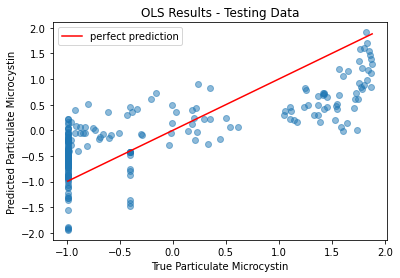

0.603767261875858

In [9]:
model_test_plot(ols, X_test, y_test, name='OLS', value='Particulate Microcystin', savefig=True, fname='ols_test_plot')

The OLS model shows poor performance with a mean absolute errors of approximately 0.60. The model also shows overestimation of low values and underestimation of high values, as expected due to regression to the mean. It is clear that linear models are far too underpowered for this problem so we will move on to ensemble methods.

## <a id='3'>3. Ensemble Methods - Regression, Scaled Data</a>
### <a id='3a'>3.a. Random Forest Regressor</a>

We will use random search in order to tune hyperparameters for the Random Forest (RF) model. Since the data is ordered in time we will use a time series split to ensure that testing sets always occur chronologically after the training sets. This means that the first training set will be significantly smaller than the second and third, which may impact scoring on the first few sets. However, this way we can be sure to avoid bias from giving the model access to future data.

In [10]:
#perform randomized hyperparameter search for comparison
params = {
 'max_depth': [None, 10, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rf = RandomForestRegressor()
tss = TimeSeriesSplit(n_splits=3)
rfcv = RandomizedSearchCV(rf, params, cv=tss, verbose=1, n_jobs=-1)

rfcv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.1s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   verbose=1)

In [11]:
#examine randomized search outputs
pd.DataFrame(rfcv.cv_results_).sort_values('rank_test_score').T

,3,1,0,5,2,7,6,4,8,9
mean_fit_time,4.26449,0.445215,0.876631,0.93964,0.468355,4.72789,9.90058,1.68017,0.880103,1.92664
std_fit_time,0.500113,0.0593819,0.117693,0.194419,0.0594623,1.11321,2.90763,0.520805,0.295494,0.640551
mean_score_time,0.191214,0.0248663,0.0409163,0.0456436,0.0215336,0.103185,0.188641,0.0430983,0.0209789,0.030822
std_score_time,0.00277516,0.00456277,0.00130029,0.00510316,0.000900434,0.00854543,0.0016852,0.00515378,0.000796608,0.0051841
param_n_estimators,1000,100,200,200,100,500,1000,200,100,200
param_min_samples_split,10,4,10,10,4,4,2,4,4,10
param_min_samples_leaf,4,4,4,1,1,4,4,4,4,1
param_max_features,sqrt,sqrt,sqrt,sqrt,sqrt,auto,auto,auto,auto,auto
param_max_depth,50,50,None,100,10,None,None,50,None,None
params,"{'n_estimators': 1000, 'min_samples_split': 10...","{'n_estimators': 100, 'min_samples_split': 4, ...","{'n_estimators': 200, 'min_samples_split': 10,...","{'n_estimators': 200, 'min_samples_split': 10,...","{'n_estimators': 100, 'min_samples_split': 4, ...","{'n_estimators': 500, 'min_samples_split': 4, ...","{'n_estimators': 1000, 'min_samples_split': 2,...","{'n_estimators': 200, 'min_samples_split': 4, ...","{'n_estimators': 100, 'min_samples_split': 4, ...","{'n_estimators': 200, 'min_samples_split': 10,..."


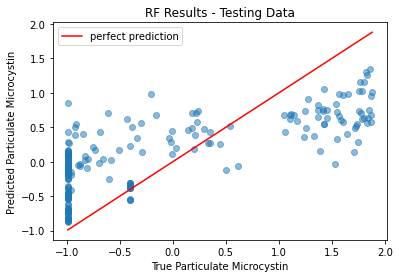

0.6726569221440508

In [12]:
rf_best = rfcv.best_estimator_
rf_best.fit(X_train, y_train)
model_test_plot(rf_best, X_test, y_test, name='RF', value='Particulate Microcystin', savefig=True, fname='rf_test_plot')

The RF model performs even worse than OLS with a mean absolute error of 0.67. There are still huge variations in predictions for given true concentrations of microcystin, and high values in particular are quite underestimated. Let's try an XGBoost model for comparison.

### <a id='3b'>3.b. XGBoost Regressor</a>

In [13]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

xgbr = xgb.XGBRegressor()
xgbcv = RandomizedSearchCV(xgbr, params, cv=tss, verbose=1, n_jobs=-1)

xgbcv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.9s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=na...
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
        

In [14]:
pd.DataFrame(xgbcv.cv_results_).sort_values('rank_test_score').T

,2,1,5,4,6,0,7,8,9,3
mean_fit_time,0.189098,0.554588,0.994555,0.401612,0.201896,0.0771326,0.772709,0.271978,0.0357496,0.269098
std_fit_time,0.0206357,0.277559,0.473965,0.194681,0.107604,0.0224087,0.319436,0.128458,0.0129682,0.116697
mean_score_time,0.00291745,0.00248257,0.00250864,0.00351906,0.00242941,0.00245142,0.00296942,0.0025208,0.00209498,0.00947507
std_score_time,0.00072179,0.000612504,4.8725e-05,0.000211029,0.000141423,3.6259e-05,0.000215435,0.00032589,0.00039658,0.00931077
param_n_estimators,20,50,100,100,20,10,100,50,10,50
param_min_child_weight,3,0.5,1,1,0.5,5,1,3,5,0.5
param_max_depth,100,100,50,100,50,10,50,10,None,None
param_learning_rate,0.1,0.2,0.2,0.3,0.2,0.1,0.01,0.01,0.01,0.001
param_gamma,0,0.5,0.25,0,0.5,1,1,0,0.5,0.25
param_colsample_bytree,0.8,0.7,0.8,0.7,1,0.7,1,0.9,0.7,1


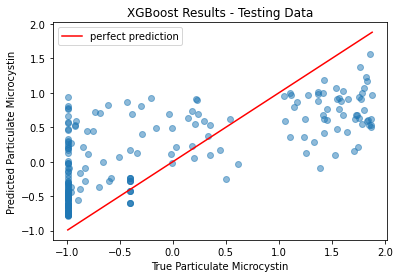

0.6768289851670605

In [15]:
xgbr_best = xgbcv.best_estimator_
xgbr_best.fit(X_train, y_train)
model_test_plot(xgbr_best, X_test, y_test, name='XGBoost', value='Particulate Microcystin', savefig=True, fname='xgb_test_plot')

The XGBoost model performs about the same as the RF model with an MAE of 0.68. Additionally the large errors in high particulate microcystin concentrations on the log-transformed data will correspond to even larger absolute errors on the original data. 

## <a id='4'>4. Ensemble Methods - Regression, Unscaled Features</a>
### <a id='4a'>4.a. Random Forest Regressor</a>

Since decision trees use single splits to determine outcomes they don't depend on scaling in principal. However, scaling will affect the optimization of a decision tree for a regression problem since varying transformations will affect the magnitude of the residuals. Given the poor performance of scaled features especially for large microcystin concentrations we will explore unscaled features here. 

In [16]:
#select past features and separate into training and testing split
X_unscaled = unscaled.drop(columns='Particulate Microcystin (µg/L)').values
y_unscaled = unscaled['Particulate Microcystin (µg/L)'].values

X_us_train, X_us_test, y_us_train, y_us_test = train_test_split(X_unscaled, y_unscaled, test_size=0.2, shuffle=False)

In [17]:
#perform randomized hyperparameter search on unscaled features
params = {
 'max_depth': [None, 10, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rf_us = RandomForestRegressor()
rf_us_cv = RandomizedSearchCV(rf_us, params, cv=tss, verbose=1, n_jobs=-1)

rf_us_cv.fit(X_us_train, y_us_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.9s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   verbose=1)

In [18]:
#examine output
pd.DataFrame(rf_us_cv.cv_results_).sort_values('rank_test_score').T

,6,8,7,1,5,2,4,9,3,0
mean_fit_time,0.871706,0.738519,1.04192,0.734572,5.53552,2.23458,2.81372,10.3304,1.97941,1.6187
std_fit_time,0.108586,0.263461,0.27985,0.110726,1.43838,0.743122,0.92713,2.6721,0.445348,0.646651
mean_score_time,0.0404246,0.0847839,0.0579879,0.047492,0.234502,0.025941,0.0402714,0.147267,0.0382612,0.0267752
std_score_time,0.00114961,0.0848572,0.0201873,0.0330968,0.0289375,0.00677065,0.0018558,0.027355,0.0218839,0.00669445
param_n_estimators,200,100,200,100,1000,100,200,1000,100,100
param_min_samples_split,10,2,10,2,2,4,10,2,2,10
param_min_samples_leaf,4,4,4,1,1,1,1,4,1,4
param_max_features,sqrt,sqrt,sqrt,sqrt,sqrt,auto,auto,auto,auto,auto
param_max_depth,50,10,10,50,None,None,None,None,100,50
params,"{'n_estimators': 200, 'min_samples_split': 10,...","{'n_estimators': 100, 'min_samples_split': 2, ...","{'n_estimators': 200, 'min_samples_split': 10,...","{'n_estimators': 100, 'min_samples_split': 2, ...","{'n_estimators': 1000, 'min_samples_split': 2,...","{'n_estimators': 100, 'min_samples_split': 4, ...","{'n_estimators': 200, 'min_samples_split': 10,...","{'n_estimators': 1000, 'min_samples_split': 2,...","{'n_estimators': 100, 'min_samples_split': 2, ...","{'n_estimators': 100, 'min_samples_split': 10,..."


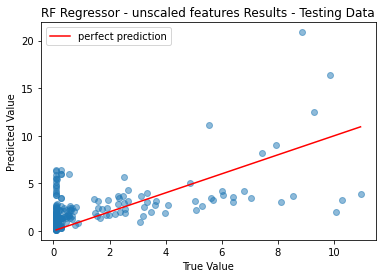

1.6739708763461258

In [19]:
#fit best estimator and calculate mean absolute error of the training set.
rf_us_best = rf_us_cv.best_estimator_
rf_us_best.fit(X_us_train, y_us_train)
model_test_plot(rf_us_best, X_test=X_us_test, y_test=y_us_test, name='RF Regressor - unscaled features',
                savefig=True, fname='rf_us_regression')

The RF regressor has an MAE of 1.67 µg/L on the test set and seems to underestimate elevated concentrations of microcystin. Overall the RF regressor cannot distinguish between low and high concentrations.

### <a id='4b'>4.a. XGBoost Regressor</a>

In [20]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

xgbr_us = xgb.XGBRegressor()

xgbcv_us = RandomizedSearchCV(xgbr_us, params, cv=tss, verbose=1, n_jobs=-1)

xgbcv_us.fit(X_us_train, y_us_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    1.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=na...
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
        

In [21]:
#examine random search results
pd.DataFrame(xgbcv_us.cv_results_).sort_values('rank_test_score').T

,8,7,5,4,1,6,0,3,9,2
mean_fit_time,0.138136,0.620459,0.103517,0.0968297,0.0744806,0.119324,0.261931,1.6322,1.8153,0.450452
std_fit_time,0.100514,0.434664,0.038222,0.0503697,0.0269922,0.0440643,0.107191,0.797656,0.470655,0.173176
mean_score_time,0.0023156,0.00599782,0.00224519,0.00461698,0.0026768,0.00235343,0.0057102,0.00949415,0.00357676,0.00319227
std_score_time,0.000104465,0.00291979,0.000119142,0.00345708,0.000416192,0.000102804,0.00408406,0.0051991,0.00125136,0.000257048
param_n_estimators,10,100,10,10,10,10,50,100,100,50
param_min_child_weight,0.5,5,0.5,3,1,0.5,5,3,3,0.5
param_max_depth,100,10,50,10,10,100,None,100,50,10
param_learning_rate,0.001,0.01,0.1,0.1,0.3,0.2,0.3,0.3,0.3,0.1
param_gamma,1,0.5,0,0.25,0.5,0.25,0.5,0,0.5,0
param_colsample_bytree,0.8,0.5,0.7,1,0.5,0.9,0.7,0.8,1,0.9


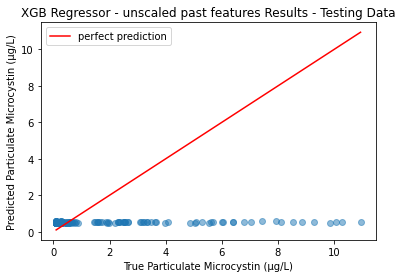

1.2867421573593203

In [22]:
xgbus_best = xgbcv_us.best_estimator_
xgbus_best.fit(X_us_train, y_us_train)
model_test_plot(xgbus_best, X_us_test, y_us_test, name='XGB Regressor - unscaled past features', 
                value='Particulate Microcystin (µg/L)', savefig=True, fname='xgb_us_regression')

Here the XGBoost model has a slightly better MAE than the RF regressor (1.29 µg/L on the test set). However this is clearly because the model mostly predicts a low concentration for all points. It is again unable to distinguish between low and elevated microcystin concentrations.

While it would be nice to have a prediction that estimates exact microcystin concentration our goals pertain more to accurate identification and prediction of high concentration samples as a class. Therefore it may be better, and hopefully more effective, to approach this as a classification problem. From an application and policy standpoint the response to a concentration of 8 µg/L versus 6 µg/L is much the same, what is really important is predicting where a sample will fall in the spectrum of EPA concentration categories.

## <a id='5'>5. Binary Classification with Ensemble Methods</a>
### <a id='5a'>5.a. Random Forest Classifier</a>

We will start with binary classification. Although there is not a particular cutoff for particulate microcystin that indicates the definitive presence of a harmful algal bloom we can reasonably use the EPA drinking cutoff of 1.6 µg/L.

In [23]:
#define function for sorting particulate microcystin concentrations into categories
def pm_bin(pm):
    if pm < 1.6:
        return 0
    else:
        return 1

y_bin = unscaled['Particulate Microcystin (µg/L)'].apply(lambda x: pm_bin(x)).values
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_unscaled, y_bin, test_size=0.2, shuffle=False)

In [24]:
print(sum(y_bin == 0), 'samples below 1.6 µg/L')
print(sum(y_bin == 1), 'samples at or above 1.6 µg/L')

844 samples below 1.6 µg/L
229 samples at or above 1.6 µg/L


The classes are fairly imbalanced so we will use balanced accuracy as a scoring metric to incentivize identifying higher particulate microcystin samples.

In [25]:
#perform randomized hyperparameter search on unscaled features
params = {
 'max_depth': [None, 10, 50, 100],
 'criterion': ['gini', 'entropy'],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rfbin = RandomForestClassifier()
rfbin_cv = RandomizedSearchCV(rfbin, params, cv=tss, verbose=1, n_jobs=-1, scoring='balanced_accuracy')

rfbin_cv.fit(X_bin_train, y_bin_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.9s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   scoring='balanced_accuracy', verbose=1)

In [26]:
#examine cv results
pd.DataFrame(rfbin_cv.cv_results_).sort_values('rank_test_score').T

,7,1,4,9,5,0,6,8,3,2
mean_fit_time,7.53554,2.49901,4.80499,4.95754,1.98148,3.36943,0.667781,5.86874,7.17773,0.54248
std_fit_time,0.737948,0.153946,1.27868,0.509097,0.408556,0.491071,0.0521415,0.829081,1.60256,0.0937427
mean_score_time,0.323936,0.155598,0.321298,0.209734,0.0991924,0.13827,0.0336591,0.311743,0.582071,0.0287129
std_score_time,0.0521583,0.0226791,0.201903,0.0431108,0.0473593,0.00155536,0.0047677,0.0544485,0.211677,5.59251e-05
param_n_estimators,1000,500,500,1000,200,500,100,1000,1000,100
param_min_samples_split,10,2,2,2,4,2,10,2,2,2
param_min_samples_leaf,4,4,4,4,1,1,4,4,1,1
param_max_features,auto,sqrt,auto,auto,sqrt,auto,auto,auto,auto,auto
param_max_depth,None,10,10,10,50,100,100,50,100,100
param_criterion,gini,gini,entropy,entropy,entropy,entropy,entropy,gini,gini,entropy


In [27]:
rfbin_best = rfbin_cv.best_estimator_
rfbin_best.fit(X_bin_train, y_bin_train)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1000)

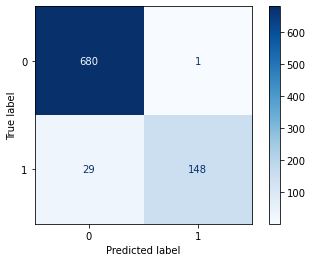

In [28]:
plot_confusion_matrix(rfbin_best, X_bin_train, y_bin_train, cmap='Blues')
plt.show()

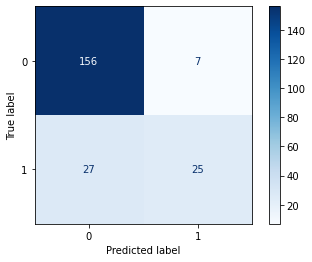

In [29]:
plot_confusion_matrix(rfbin_best, X_bin_test, y_bin_test, cmap='Blues')
plt.show()

In [30]:
pd.DataFrame(precision_recall_fscore_support(y_bin_test, rfbin_best.predict(X_bin_test)), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1
Precision,0.852459,0.781250
Recall,0.957055,0.480769
Fscore,0.901734,0.595238
Support,163.000000,52.000000


The RF binary classifier is able to catch 48% of the samples with concentrations above 1.6 µg/L. This is poor performance but it can distinguish somewhat between very low concentrations and elevated concentrations of particulate microcystin. Recall is the most notable metric for our application since our goal is to identify all HAB events. A false-positive event is an annoyance, but not predicting a bloom that then happens is more detrimental. If the baseline model were to guess randomly using the positive weight as the probability that a sample is a high concentration then we would expect a recall of 52/(52+163) = 0.24, so it is better than the recall relative to guessing.

We hope to use this data to predict microcystin values in future seasons. We expect that ecological dynamics could meaningfully change from one year to the next, which would decrease the effectiveness of the model from year to year. This can be checked using time series split cross-validation.

In [31]:
#check for consistency across unshuffled cross-validation splits.
cvs = cross_val_score(rfbin_best, X_unscaled, y_bin, cv=tss, scoring='recall')
print('Average recall:', np.mean(cvs), '\n' + 'Std recall:' + str(np.std(cvs)))

cvs = cross_val_score(rfbin_best, X_unscaled, y_bin, cv=tss, scoring='precision')
print('Average precision:', np.mean(cvs), '\n' + 'Std precision:' + str(np.std(cvs)))

Average recall: 0.6210028047673007 
Std recall:0.06722074439104933
Average precision: 0.5703867386789154 
Std precision:0.1350482881511195


We can look at tuning the model's recall by sacrificing precision with a precision / recall curve. Again, recall is more important than precision for our application since our goal is to warn of impending algal blooms, and a false positive is just an annoyance while a false negative is a missed warning. We can perhaps adjust the model thresholds to improve recall while accepting worse precision. In order to do this we will need to make a training and testing split from our original traning set.

In [32]:
X_thresh_train, X_thresh_test, y_thresh_train, y_thresh_test = train_test_split(X_bin_train, y_bin_train, test_size=0.2, shuffle=False)
rfbin_best.fit(X_thresh_train, y_thresh_train)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1000)

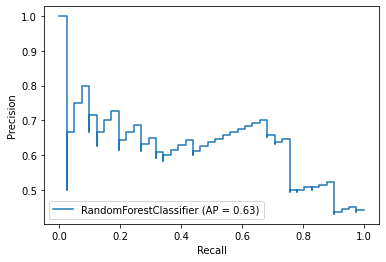

In [33]:
plot_precision_recall_curve(rfbin_best, X_thresh_test, y_thresh_test)

We could potentially improve the recall to about 0.70 if we are willing to accept a decrease in precision to about 0.65. We can look at this another way with the ROC curve.

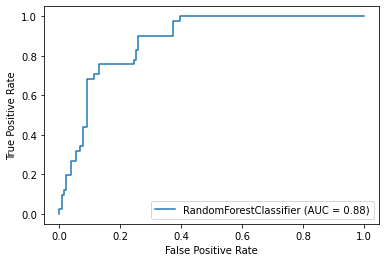

In [34]:
plot_roc_curve(rfbin_best, X_thresh_test, y_thresh_test)

We can generate the precision, recall, and threshold data to select a threshold that better corresponds to the project goals of higher recall.

In [35]:
#predict probabilities
y_bin_probs = rfbin_best.predict_proba(X_thresh_test)
y_probs = y_bin_probs[:,1]

#calculate precision recall curve data and input into df
prec, recall, thr = precision_recall_curve(y_thresh_test, y_probs)
prec = prec[:-1]
recall = recall[:-1]
PR_df = pd.DataFrame({'threshold': thr, 'precision': prec, 'recall': recall})

In [36]:
PR_df[(PR_df['recall'] > 0.6) & (PR_df['precision'] > 0.5)]

,threshold,precision,recall
20,0.295115,0.506849,0.902439
21,0.295825,0.513889,0.902439
22,0.299383,0.521127,0.902439
23,0.300654,0.514286,0.878049
24,0.300772,0.507246,0.853659
26,0.307434,0.507463,0.829268
32,0.362738,0.508197,0.756098
33,0.363479,0.516667,0.756098
34,0.363905,0.525424,0.756098
35,0.377771,0.534483,0.756098


A threshold of 0.504567 improves the precision of the test set to 0.71 while maintaining a precision of above 0.65.

In [37]:
#calculate precision and recall using new threshold with cross validation for year to year comparison
precs = []
recalls = []

for tr_i, te_i in tss.split(X_unscaled):
    
    #make training and testing set
    X_tr, X_te = X_unscaled[tr_i], X_unscaled[te_i]
    y_tr, y_te = y_bin[tr_i], y_bin[te_i]
    
    #train model and predict probabilities on test set
    rfbin_best.fit(X_tr, y_tr)
    y_probs = rfbin_best.predict_proba(X_te)[:,1]
    
    #determine predictions based on probability threshold 
    threshold = 0.504567
    y_pr = np.array([int(i) for i in (y_probs > threshold)])
    
    #score and add scores to lists
    scores = precision_recall_fscore_support(y_te, y_pr)
    precs.append(scores[0][1])
    recalls.append(scores[1][1])
    
print('precisions:', precs)
print('recalls:', recalls)
print('Avg precision:', np.mean(precs), '+ / -', np.std(precs))
print('Avg recall:', np.mean(recalls), '+ / -', np.std(recalls))

precisions: [0.36585365853658536, 0.6842105263157895, 0.6551724137931034]
recalls: [0.5263157894736842, 0.7027027027027027, 0.6440677966101694]
Avg precision: 0.5684121995484928 + / - 0.14372027205043011
Avg recall: 0.6243620962621854 + / - 0.07334540094315722


In [52]:
#test the final estimator on the original test set
rfbin_best.fit(X_bin_train, y_bin_train)
y_probs = rfbin_best.predict_proba(X_bin_test)[:,1]
threshold = 0.504567
y_pr = np.array([int(i) for i in (y_probs > threshold)])
pd.DataFrame(precision_recall_fscore_support(y_bin_test, y_pr), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1
Precision,0.857143,0.787879
Recall,0.957055,0.500000
Fscore,0.904348,0.611765
Support,163.000000,52.000000


### <a id='5b'>5.b. XGBoost Binary Classifier</a>

In [39]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1],
    'objective': ['binary:logistic']
}

xgbbin = xgb.XGBClassifier()
xgbbin_cv = RandomizedSearchCV(xgbbin, params, cv=tss, verbose=1, n_jobs=-1, scoring='balanced_accuracy')
xgbbin_cv.fit(X_bin_train, y_bin_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.5s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=n...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=None),
                   n_jobs=-1,
                   param_distrib

In [40]:
pd.DataFrame(xgbbin_cv.cv_results_).sort_values('rank_test_score').T

,3,2,9,1,5,7,0,6,4,8
mean_fit_time,0.130269,0.0842656,0.406749,0.147097,0.42904,0.0943979,0.882359,0.0797623,0.482278,0.0719857
std_fit_time,0.0710342,0.0443819,0.135863,0.0447362,0.204492,0.0474504,0.436512,0.0363446,0.248484,0.0470836
mean_score_time,0.00277988,0.00380603,0.00577044,0.00663718,0.00473698,0.00620659,0.0127694,0.00998878,0.0146071,0.0270403
std_score_time,0.000690442,0.000474633,0.00188052,0.00431658,0.000537478,0.000784055,0.00431911,0.0077511,0.0149686,0.0252226
param_objective,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic
param_n_estimators,20,20,100,20,50,20,100,10,50,10
param_min_child_weight,5,3,5,1,1,3,0.5,5,3,3
param_max_depth,None,100,50,100,None,None,100,10,None,None
param_learning_rate,0.2,0.1,0.001,0.1,0.2,0.01,0.01,0.01,0.01,0.001
param_gamma,0.5,1,0.5,0,0,0.5,0,1,0.5,0.25


In [41]:
xgbbin_best = xgbbin_cv.best_estimator_
xgbbin_best.fit(X_bin_train, y_bin_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=5.0, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

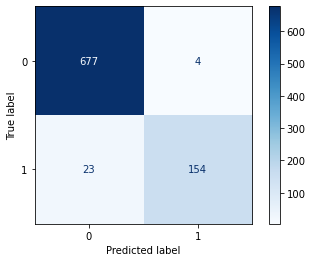

In [42]:
plot_confusion_matrix(xgbbin_best, X_bin_train, y_bin_train, cmap='Blues')
plt.show()

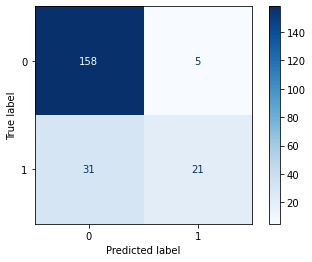

In [43]:
plot_confusion_matrix(xgbbin_best, X_bin_test, y_bin_test, cmap='Blues')
plt.show()

In [44]:
y_xgbbin_pred = xgbbin_best.predict(X_bin_test)
pd.DataFrame(precision_recall_fscore_support(y_bin_test, y_xgbbin_pred), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1
Precision,0.835979,0.807692
Recall,0.969325,0.403846
Fscore,0.897727,0.538462
Support,163.000000,52.000000


As with the RF model we can check for consistency using time series split cross-validation.

In [45]:
#check for consistency across unshuffled cross-validation splits
cvs = cross_val_score(xgbbin_best, X_unscaled, y_bin, cv=tss, scoring='recall')
print('Average recall:', np.mean(cvs), '\n' + 'Std recall:' + str(np.std(cvs)))

cvs = cross_val_score(xgbbin_best, X_unscaled, y_bin, cv=tss, scoring='precision')
print('Average precision:', np.mean(cvs), '\n' + 'Std precision:' + str(np.std(cvs)))

Average recall: 0.6149566158486764 
Std recall:0.08749429037999487
Average precision: 0.487266448022262 
Std precision:0.12066904719905427


The XGBoost binary classifier performs slightly worse on our test set than the RF binary regressor with a recall of 0.61, and in cross-validation it has a significantly worse precision (0.48 versus 0.57). The average recall is better than twice the expected recall from the dummy average model.

We can again tune the model to optimize recall.

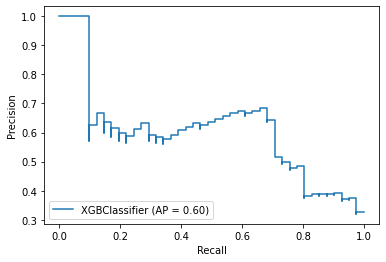

In [46]:
xgbbin_best.fit(X_thresh_train, y_thresh_train)
plot_precision_recall_curve(xgbbin_best, X_thresh_test, y_thresh_test)

It seems we could increase our recall to 0.7 if we are willing to accept a reduced precision of about 0.65. To look at this another way here is the ROC curve.

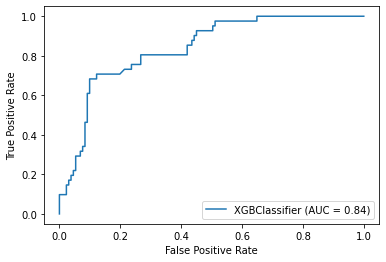

In [47]:
plot_roc_curve(xgbbin_best, X_thresh_test, y_thresh_test)

In [48]:
y_bin_probs = xgbbin_best.predict_proba(X_thresh_test)
y_probs = y_bin_probs[:,1]
prec, recall, thr = precision_recall_curve(y_thresh_test, y_probs)
prec = prec[:-1]
recall = recall[:-1]
PR_df = pd.DataFrame({'threshold': thr, 'precision': prec, 'recall': recall})

In [49]:
PR_df[(PR_df['recall'] > 0.6) & (PR_df['precision'] > 0.5)]

,threshold,precision,recall
65,0.455362,0.508475,0.731707
66,0.456843,0.517241,0.731707
67,0.466711,0.527273,0.707317
68,0.470289,0.537037,0.707317
69,0.480076,0.547170,0.707317
70,0.481649,0.557692,0.707317
71,0.495654,0.568627,0.707317
72,0.503792,0.580000,0.707317
73,0.543479,0.591837,0.707317
74,0.545421,0.604167,0.707317


A threshold of 0.623693 seems to be promising for obtaining a recall close to 0.8 while maintaining a precision above 0.5.

In [50]:
#calculate precision and recall using new threshold with cross validation for year to year comparison
precs = []
recalls = []

for tr_i, te_i in tss.split(X_unscaled):
    
    #make training and testing set
    X_tr, X_te = X_unscaled[tr_i], X_unscaled[te_i]
    y_tr, y_te = y_bin[tr_i], y_bin[te_i]
    
    #train model and predict probabilities on test set
    xgbbin_best.fit(X_tr, y_tr)
    y_probs = xgbbin_best.predict_proba(X_te)[:,1]
    
    #determine predictions based on probability threshold 
    threshold = 0.623693
    y_pr = np.array([int(i) for i in (y_probs > threshold)])
    
    #score and add scores to lists
    scores = precision_recall_fscore_support(y_te, y_pr)
    precs.append(scores[0][1])
    recalls.append(scores[1][1])
    
print('precisions:', precs)
print('recalls:', recalls)
print('Avg precision:', np.mean(precs), '+ / -', np.std(precs))
print('Avg recall:', np.mean(recalls), '+ / -', np.std(recalls))

precisions: [0.3684210526315789, 0.696969696969697, 0.6538461538461539]
recalls: [0.49122807017543857, 0.6216216216216216, 0.576271186440678]
Avg precision: 0.5730789678158099 + / - 0.14578193001546053
Avg recall: 0.5630402927459127 + / - 0.05404881728991998


Overall on cross-validation the XGBoost classifier performs worse than the RF classifier. The RF classifier has an average recall of 0.62 +/- 0.07 compared to the XGBoost recall of 0.56 +/- 0.0.05. The RF classifier is therefore more sensitive than the XGBoost classifier, and about as consistent. The RF classifier is slightly less precise, with  an average precision of 0.568 +/- 0.144 versus the XGBoost precision of 0.573 +/- 0.146, however these differences are well within the margins of error.

In [51]:
#test the final estimator on the original test set
xgbbin_best.fit(X_bin_train, y_bin_train)
y_probs = xgbbin_best.predict_proba(X_bin_test)[:,1]
threshold = 0.623693
y_pr = np.array([int(i) for i in (y_probs > threshold)])
pd.DataFrame(precision_recall_fscore_support(y_bin_test, y_pr), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1
Precision,0.804020,0.812500
Recall,0.981595,0.250000
Fscore,0.883978,0.382353
Support,163.000000,52.000000


The XGBoost performs much worse than the RF classifier on our original test set with a recall of 0.25 versus 0.50. 

## <a id='6'>6. Model Recommendation and Feature Importance</a>

Ultimately for the goals of this project we would recommend the binary Random Forest classifier with an adjusted probability threshold in order to increase recall without sacrificing too much precision. Although the XGBoost classifier performed better on our original test set the RF model was more reliable with higher overall performance in cross-validation. Overall this model does provide some ability to predict elevated microcystin concentration up to two weeks in the future based on environmental features, and without using exact site location. 

We can use the SHAP package to explore feature importance in the final model.

In [53]:
#calculate shap values
explainer = shap.Explainer(rfbin_best.predict, X_bin_test)
shap_values = explainer(X_bin_test)

Permutation explainer: 216it [32:40,  9.12s/it]                         


In [54]:
feature_names = unscaled.drop(columns='Particulate Microcystin (µg/L)').columns
shap_values.feature_names = feature_names

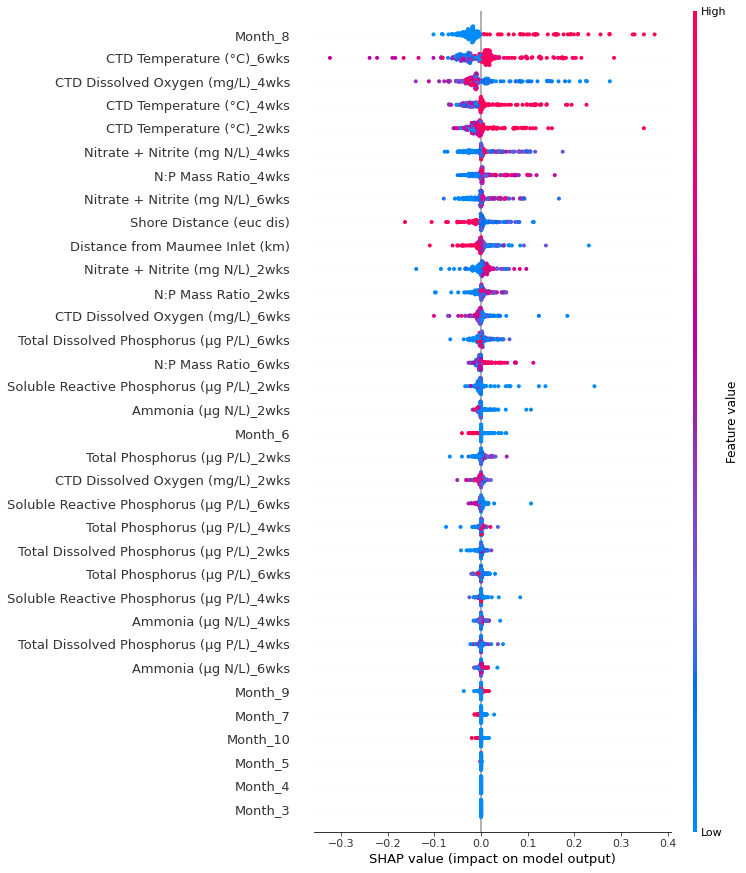

In [55]:
shap.plots.beeswarm(shap_values)

For the most part the feature importance is quite intuitive and in alignment with understanding of what factors promote the growth of harmful algal blooms. High temperatures are quite important, and it is especially interesting that high temperatures well in advance of the prediction date are the most influential. It is, however, surprising that there are cases where high temperature lowers the model output. More decisive is whether or not the sample is collected in August, which universally increases model output. Distance from the Maumee inlet and distance from shore both have quite predictable influence - smaller distances increase model output and vice versa, which is logical since closer sites have more concentrated influx of nutrients coming from the river or agricultural runoff.

The presence of nitrogen-containing nutrients increases model output, which is logical since these nutrients promote the growth of HABs. It is interesting that nitrogen-containing compounds were more influential than dissolved phosphorus in this case. It is also quite noteworthy that at more distant times, e.g. 4 and 6 weeks in the past, high nitrogen-containing values increase the model output forecasting HAB presence, but at 2 weeks they are less impactful. This would be in line with the time lag concepts explored in the EDA notebook of nutrients peaking prior to HAB formation, but decreasing as the algae grows because the algae consumes the nutrients. Ammonia in particular follows this pattern, switching from high values increasing model output at 6 weeks, then high model decreasing model output at 2 weeks.

Finally, low dissolved oxygen decreases the model output consistently. Algae are obligate anaerobes, so it is logical that low oxygen would mean a rather inhospitable environment for a bloom.